# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 5, 5, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=5, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 5, 5, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.2080
Epoch 1/200, Iteration 2/12, Loss: 0.9407
Epoch 1/200, Iteration 3/12, Loss: 0.9837
Epoch 1/200, Iteration 4/12, Loss: 1.1842
Epoch 1/200, Iteration 5/12, Loss: 1.1412
Epoch 1/200, Iteration 6/12, Loss: 1.1237
Epoch 1/200, Iteration 7/12, Loss: 1.1840
Epoch 1/200, Iteration 8/12, Loss: 0.9325
Epoch 1/200, Iteration 9/12, Loss: 0.9961
Epoch 1/200, Iteration 10/12, Loss: 0.8951
Epoch 1/200, Iteration 11/12, Loss: 0.8841
Epoch 1/200, Iteration 12/12, Loss: 0.9343
Epoch 1/200, Iteration 13/12, Loss: 0.7175
Train Error: 
 Accuracy: 46.25%, Avg loss: 0.898319, MRE: 0.661855, MAE: 0.105500 

Test Error: 
 Accuracy: 49.0%, Avg loss: 0.793161, MRE: 0.532716, MAE: 0.091759 

Epoch 2/200, Iteration 1/12, Loss: 0.9637
Epoch 2/200, Iteration 2/12, Loss: 0.8929
Epoch 2/200, Iteration 3/12, Loss: 0.8042
Epoch 2/200, Iteration 4/12, Loss: 0.9679
Epoch 2/200, Iteration 5/12, Loss: 0.8595
Epoch 2/200, Iteration 6/12, Loss: 0.7665
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 86.38%, Avg loss: 0.024173, MRE: 0.065827, MAE: 0.012800 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.016732, MRE: 0.058820, MAE: 0.012459 

Epoch 13/200, Iteration 1/12, Loss: 0.0293
Epoch 13/200, Iteration 2/12, Loss: 0.0159
Epoch 13/200, Iteration 3/12, Loss: 0.0164
Epoch 13/200, Iteration 4/12, Loss: 0.0156
Epoch 13/200, Iteration 5/12, Loss: 0.0193
Epoch 13/200, Iteration 6/12, Loss: 0.0192
Epoch 13/200, Iteration 7/12, Loss: 0.0338
Epoch 13/200, Iteration 8/12, Loss: 0.0464
Epoch 13/200, Iteration 9/12, Loss: 0.0217
Epoch 13/200, Iteration 10/12, Loss: 0.0181
Epoch 13/200, Iteration 11/12, Loss: 0.0169
Epoch 13/200, Iteration 12/12, Loss: 0.0169
Epoch 13/200, Iteration 13/12, Loss: 0.0360
Train Error: 
 Accuracy: 85.88%, Avg loss: 0.021895, MRE: 0.067621, MAE: 0.012807 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.019124, MRE: 0.063221, MAE: 0.013033 

Epoch 14/200, Iteration 1/12, Loss: 0.0141
Epoch 14/200, Iteration 2/12, Loss: 0.0177
Epoch 14/200, Itera

Train Error: 
 Accuracy: 94.25%, Avg loss: 0.009998, MRE: 0.045500, MAE: 0.008013 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007428, MRE: 0.038288, MAE: 0.007808 

Epoch 26/200, Iteration 1/12, Loss: 0.0066
Epoch 26/200, Iteration 2/12, Loss: 0.0107
Epoch 26/200, Iteration 3/12, Loss: 0.0079
Epoch 26/200, Iteration 4/12, Loss: 0.0137
Epoch 26/200, Iteration 5/12, Loss: 0.0063
Epoch 26/200, Iteration 6/12, Loss: 0.0052
Epoch 26/200, Iteration 7/12, Loss: 0.0102
Epoch 26/200, Iteration 8/12, Loss: 0.0183
Epoch 26/200, Iteration 9/12, Loss: 0.0135
Epoch 26/200, Iteration 10/12, Loss: 0.0084
Epoch 26/200, Iteration 11/12, Loss: 0.0060
Epoch 26/200, Iteration 12/12, Loss: 0.0136
Epoch 26/200, Iteration 13/12, Loss: 0.0062
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.009055, MRE: 0.043015, MAE: 0.007478 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006353, MRE: 0.035195, MAE: 0.006968 

Epoch 27/200, Iteration 1/12, Loss: 0.0107
Epoch 27/200, Iteration 2/12, Loss: 0.0118
Epoch 27/200, Itera

Train Error: 
 Accuracy: 95.62%, Avg loss: 0.006062, MRE: 0.037528, MAE: 0.006741 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004231, MRE: 0.029965, MAE: 0.006258 

Epoch 38/200, Iteration 1/12, Loss: 0.0057
Epoch 38/200, Iteration 2/12, Loss: 0.0119
Epoch 38/200, Iteration 3/12, Loss: 0.0069
Epoch 38/200, Iteration 4/12, Loss: 0.0037
Epoch 38/200, Iteration 5/12, Loss: 0.0057
Epoch 38/200, Iteration 6/12, Loss: 0.0041
Epoch 38/200, Iteration 7/12, Loss: 0.0045
Epoch 38/200, Iteration 8/12, Loss: 0.0073
Epoch 38/200, Iteration 9/12, Loss: 0.0117
Epoch 38/200, Iteration 10/12, Loss: 0.0071
Epoch 38/200, Iteration 11/12, Loss: 0.0056
Epoch 38/200, Iteration 12/12, Loss: 0.0049
Epoch 38/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.006441, MRE: 0.039580, MAE: 0.007064 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.005197, MRE: 0.038383, MAE: 0.006834 

Epoch 39/200, Iteration 1/12, Loss: 0.0082
Epoch 39/200, Iteration 2/12, Loss: 0.0042
Epoch 39/200, Itera

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.006459, MRE: 0.043375, MAE: 0.007081 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005634, MRE: 0.040740, MAE: 0.006896 

Epoch 50/200, Iteration 1/12, Loss: 0.0074
Epoch 50/200, Iteration 2/12, Loss: 0.0084
Epoch 50/200, Iteration 3/12, Loss: 0.0041
Epoch 50/200, Iteration 4/12, Loss: 0.0053
Epoch 50/200, Iteration 5/12, Loss: 0.0054
Epoch 50/200, Iteration 6/12, Loss: 0.0049
Epoch 50/200, Iteration 7/12, Loss: 0.0043
Epoch 50/200, Iteration 8/12, Loss: 0.0087
Epoch 50/200, Iteration 9/12, Loss: 0.0066
Epoch 50/200, Iteration 10/12, Loss: 0.0042
Epoch 50/200, Iteration 11/12, Loss: 0.0069
Epoch 50/200, Iteration 12/12, Loss: 0.0087
Epoch 50/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005852, MRE: 0.039344, MAE: 0.006741 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.004864, MRE: 0.035631, MAE: 0.006272 

Epoch 51/200, Iteration 1/12, Loss: 0.0059
Epoch 51/200, Iteration 2/12, Loss: 0.0061
Epoch 51/200, Iterat

Train Error: 
 Accuracy: 95.62%, Avg loss: 0.004337, MRE: 0.032846, MAE: 0.006124 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003257, MRE: 0.026380, MAE: 0.005636 

Epoch 62/200, Iteration 1/12, Loss: 0.0033
Epoch 62/200, Iteration 2/12, Loss: 0.0039
Epoch 62/200, Iteration 3/12, Loss: 0.0047
Epoch 62/200, Iteration 4/12, Loss: 0.0039
Epoch 62/200, Iteration 5/12, Loss: 0.0025
Epoch 62/200, Iteration 6/12, Loss: 0.0066
Epoch 62/200, Iteration 7/12, Loss: 0.0043
Epoch 62/200, Iteration 8/12, Loss: 0.0041
Epoch 62/200, Iteration 9/12, Loss: 0.0048
Epoch 62/200, Iteration 10/12, Loss: 0.0066
Epoch 62/200, Iteration 11/12, Loss: 0.0037
Epoch 62/200, Iteration 12/12, Loss: 0.0045
Epoch 62/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004327, MRE: 0.032894, MAE: 0.006104 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003283, MRE: 0.026497, MAE: 0.005643 

Epoch 63/200, Iteration 1/12, Loss: 0.0024
Epoch 63/200, Iteration 2/12, Loss: 0.0028
Epoch 63/200, Itera

Train Error: 
 Accuracy: 95.75%, Avg loss: 0.004246, MRE: 0.032568, MAE: 0.006071 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003178, MRE: 0.026415, MAE: 0.005604 

Epoch 74/200, Iteration 1/12, Loss: 0.0038
Epoch 74/200, Iteration 2/12, Loss: 0.0030
Epoch 74/200, Iteration 3/12, Loss: 0.0068
Epoch 74/200, Iteration 4/12, Loss: 0.0034
Epoch 74/200, Iteration 5/12, Loss: 0.0045
Epoch 74/200, Iteration 6/12, Loss: 0.0057
Epoch 74/200, Iteration 7/12, Loss: 0.0067
Epoch 74/200, Iteration 8/12, Loss: 0.0031
Epoch 74/200, Iteration 9/12, Loss: 0.0023
Epoch 74/200, Iteration 10/12, Loss: 0.0051
Epoch 74/200, Iteration 11/12, Loss: 0.0040
Epoch 74/200, Iteration 12/12, Loss: 0.0032
Epoch 74/200, Iteration 13/12, Loss: 0.0058
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004311, MRE: 0.033383, MAE: 0.006166 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003341, MRE: 0.026221, MAE: 0.005684 

Epoch 75/200, Iteration 1/12, Loss: 0.0033
Epoch 75/200, Iteration 2/12, Loss: 0.0041
Epoch 75/200, Itera

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004194, MRE: 0.033063, MAE: 0.006066 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003091, MRE: 0.025657, MAE: 0.005562 

Epoch 86/200, Iteration 1/12, Loss: 0.0060
Epoch 86/200, Iteration 2/12, Loss: 0.0066
Epoch 86/200, Iteration 3/12, Loss: 0.0040
Epoch 86/200, Iteration 4/12, Loss: 0.0070
Epoch 86/200, Iteration 5/12, Loss: 0.0049
Epoch 86/200, Iteration 6/12, Loss: 0.0024
Epoch 86/200, Iteration 7/12, Loss: 0.0046
Epoch 86/200, Iteration 8/12, Loss: 0.0032
Epoch 86/200, Iteration 9/12, Loss: 0.0028
Epoch 86/200, Iteration 10/12, Loss: 0.0041
Epoch 86/200, Iteration 11/12, Loss: 0.0029
Epoch 86/200, Iteration 12/12, Loss: 0.0031
Epoch 86/200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.004278, MRE: 0.032380, MAE: 0.006103 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003233, MRE: 0.026581, MAE: 0.005635 

Epoch 87/200, Iteration 1/12, Loss: 0.0033
Epoch 87/200, Iteration 2/12, Loss: 0.0056
Epoch 87/200, Itera

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004183, MRE: 0.032958, MAE: 0.006086 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003050, MRE: 0.025588, MAE: 0.005528 

Epoch 98/200, Iteration 1/12, Loss: 0.0025
Epoch 98/200, Iteration 2/12, Loss: 0.0062
Epoch 98/200, Iteration 3/12, Loss: 0.0038
Epoch 98/200, Iteration 4/12, Loss: 0.0032
Epoch 98/200, Iteration 5/12, Loss: 0.0065
Epoch 98/200, Iteration 6/12, Loss: 0.0036
Epoch 98/200, Iteration 7/12, Loss: 0.0044
Epoch 98/200, Iteration 8/12, Loss: 0.0055
Epoch 98/200, Iteration 9/12, Loss: 0.0032
Epoch 98/200, Iteration 10/12, Loss: 0.0027
Epoch 98/200, Iteration 11/12, Loss: 0.0028
Epoch 98/200, Iteration 12/12, Loss: 0.0053
Epoch 98/200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004127, MRE: 0.032865, MAE: 0.006025 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003060, MRE: 0.025613, MAE: 0.005534 

Epoch 99/200, Iteration 1/12, Loss: 0.0059
Epoch 99/200, Iteration 2/12, Loss: 0.0030
Epoch 99/200, Itera

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004108, MRE: 0.032356, MAE: 0.006012 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003070, MRE: 0.025588, MAE: 0.005552 

Epoch 110/200, Iteration 1/12, Loss: 0.0041
Epoch 110/200, Iteration 2/12, Loss: 0.0053
Epoch 110/200, Iteration 3/12, Loss: 0.0040
Epoch 110/200, Iteration 4/12, Loss: 0.0039
Epoch 110/200, Iteration 5/12, Loss: 0.0058
Epoch 110/200, Iteration 6/12, Loss: 0.0030
Epoch 110/200, Iteration 7/12, Loss: 0.0035
Epoch 110/200, Iteration 8/12, Loss: 0.0037
Epoch 110/200, Iteration 9/12, Loss: 0.0040
Epoch 110/200, Iteration 10/12, Loss: 0.0042
Epoch 110/200, Iteration 11/12, Loss: 0.0030
Epoch 110/200, Iteration 12/12, Loss: 0.0040
Epoch 110/200, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.004223, MRE: 0.032806, MAE: 0.006080 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003071, MRE: 0.025583, MAE: 0.005550 

Epoch 111/200, Iteration 1/12, Loss: 0.0041
Epoch 111/200, Iteration 2/12, Loss: 0.0041
Epoch

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004099, MRE: 0.032459, MAE: 0.006025 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003102, MRE: 0.025613, MAE: 0.005564 

Epoch 122/200, Iteration 1/12, Loss: 0.0032
Epoch 122/200, Iteration 2/12, Loss: 0.0031
Epoch 122/200, Iteration 3/12, Loss: 0.0050
Epoch 122/200, Iteration 4/12, Loss: 0.0032
Epoch 122/200, Iteration 5/12, Loss: 0.0088
Epoch 122/200, Iteration 6/12, Loss: 0.0035
Epoch 122/200, Iteration 7/12, Loss: 0.0030
Epoch 122/200, Iteration 8/12, Loss: 0.0077
Epoch 122/200, Iteration 9/12, Loss: 0.0034
Epoch 122/200, Iteration 10/12, Loss: 0.0040
Epoch 122/200, Iteration 11/12, Loss: 0.0028
Epoch 122/200, Iteration 12/12, Loss: 0.0031
Epoch 122/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004080, MRE: 0.032344, MAE: 0.005999 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003095, MRE: 0.025543, MAE: 0.005559 

Epoch 123/200, Iteration 1/12, Loss: 0.0039
Epoch 123/200, Iteration 2/12, Loss: 0.0041
Epoc

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004089, MRE: 0.032355, MAE: 0.006013 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003117, MRE: 0.025593, MAE: 0.005574 

Epoch 134/200, Iteration 1/12, Loss: 0.0031
Epoch 134/200, Iteration 2/12, Loss: 0.0030
Epoch 134/200, Iteration 3/12, Loss: 0.0059
Epoch 134/200, Iteration 4/12, Loss: 0.0038
Epoch 134/200, Iteration 5/12, Loss: 0.0028
Epoch 134/200, Iteration 6/12, Loss: 0.0038
Epoch 134/200, Iteration 7/12, Loss: 0.0078
Epoch 134/200, Iteration 8/12, Loss: 0.0045
Epoch 134/200, Iteration 9/12, Loss: 0.0048
Epoch 134/200, Iteration 10/12, Loss: 0.0028
Epoch 134/200, Iteration 11/12, Loss: 0.0025
Epoch 134/200, Iteration 12/12, Loss: 0.0028
Epoch 134/200, Iteration 13/12, Loss: 0.0084
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004109, MRE: 0.032378, MAE: 0.006038 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003115, MRE: 0.025597, MAE: 0.005574 

Epoch 135/200, Iteration 1/12, Loss: 0.0055
Epoch 135/200, Iteration 2/12, Loss: 0.0035
Epoc

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004116, MRE: 0.032818, MAE: 0.006044 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025579, MAE: 0.005569 

Epoch 147/200, Iteration 1/12, Loss: 0.0046
Epoch 147/200, Iteration 2/12, Loss: 0.0030
Epoch 147/200, Iteration 3/12, Loss: 0.0033
Epoch 147/200, Iteration 4/12, Loss: 0.0067
Epoch 147/200, Iteration 5/12, Loss: 0.0030
Epoch 147/200, Iteration 6/12, Loss: 0.0056
Epoch 147/200, Iteration 7/12, Loss: 0.0028
Epoch 147/200, Iteration 8/12, Loss: 0.0092
Epoch 147/200, Iteration 9/12, Loss: 0.0029
Epoch 147/200, Iteration 10/12, Loss: 0.0024
Epoch 147/200, Iteration 11/12, Loss: 0.0036
Epoch 147/200, Iteration 12/12, Loss: 0.0029
Epoch 147/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004099, MRE: 0.032620, MAE: 0.006056 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025578, MAE: 0.005569 

Epoch 148/200, Iteration 1/12, Loss: 0.0065
Epoch 148/200, Iteration 2/12, Loss: 0.0034
Epoc

Epoch 159/200, Iteration 12/12, Loss: 0.0046
Epoch 159/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004240, MRE: 0.032661, MAE: 0.006083 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 160/200, Iteration 1/12, Loss: 0.0037
Epoch 160/200, Iteration 2/12, Loss: 0.0035
Epoch 160/200, Iteration 3/12, Loss: 0.0043
Epoch 160/200, Iteration 4/12, Loss: 0.0033
Epoch 160/200, Iteration 5/12, Loss: 0.0038
Epoch 160/200, Iteration 6/12, Loss: 0.0029
Epoch 160/200, Iteration 7/12, Loss: 0.0031
Epoch 160/200, Iteration 8/12, Loss: 0.0052
Epoch 160/200, Iteration 9/12, Loss: 0.0068
Epoch 160/200, Iteration 10/12, Loss: 0.0034
Epoch 160/200, Iteration 11/12, Loss: 0.0035
Epoch 160/200, Iteration 12/12, Loss: 0.0034
Epoch 160/200, Iteration 13/12, Loss: 0.0097
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004082, MRE: 0.032437, MAE: 0.005996 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Ep

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004109, MRE: 0.032218, MAE: 0.006012 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 172/200, Iteration 1/12, Loss: 0.0025
Epoch 172/200, Iteration 2/12, Loss: 0.0029
Epoch 172/200, Iteration 3/12, Loss: 0.0050
Epoch 172/200, Iteration 4/12, Loss: 0.0037
Epoch 172/200, Iteration 5/12, Loss: 0.0062
Epoch 172/200, Iteration 6/12, Loss: 0.0053
Epoch 172/200, Iteration 7/12, Loss: 0.0042
Epoch 172/200, Iteration 8/12, Loss: 0.0045
Epoch 172/200, Iteration 9/12, Loss: 0.0034
Epoch 172/200, Iteration 10/12, Loss: 0.0065
Epoch 172/200, Iteration 11/12, Loss: 0.0033
Epoch 172/200, Iteration 12/12, Loss: 0.0030
Epoch 172/200, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004317, MRE: 0.032911, MAE: 0.006044 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 173/200, Iteration 1/12, Loss: 0.0043
Epoch 173/200, Iteration 2/12, Loss: 0.0024
Epoc

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004172, MRE: 0.032525, MAE: 0.006089 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 184/200, Iteration 1/12, Loss: 0.0047
Epoch 184/200, Iteration 2/12, Loss: 0.0036
Epoch 184/200, Iteration 3/12, Loss: 0.0027
Epoch 184/200, Iteration 4/12, Loss: 0.0073
Epoch 184/200, Iteration 5/12, Loss: 0.0037
Epoch 184/200, Iteration 6/12, Loss: 0.0030
Epoch 184/200, Iteration 7/12, Loss: 0.0045
Epoch 184/200, Iteration 8/12, Loss: 0.0056
Epoch 184/200, Iteration 9/12, Loss: 0.0038
Epoch 184/200, Iteration 10/12, Loss: 0.0033
Epoch 184/200, Iteration 11/12, Loss: 0.0036
Epoch 184/200, Iteration 12/12, Loss: 0.0046
Epoch 184/200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004093, MRE: 0.032406, MAE: 0.006022 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 185/200, Iteration 1/12, Loss: 0.0038
Epoch 185/200, Iteration 2/12, Loss: 0.0045
Epoc

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004060, MRE: 0.032233, MAE: 0.005994 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 196/200, Iteration 1/12, Loss: 0.0036
Epoch 196/200, Iteration 2/12, Loss: 0.0034
Epoch 196/200, Iteration 3/12, Loss: 0.0051
Epoch 196/200, Iteration 4/12, Loss: 0.0068
Epoch 196/200, Iteration 5/12, Loss: 0.0059
Epoch 196/200, Iteration 6/12, Loss: 0.0033
Epoch 196/200, Iteration 7/12, Loss: 0.0038
Epoch 196/200, Iteration 8/12, Loss: 0.0034
Epoch 196/200, Iteration 9/12, Loss: 0.0045
Epoch 196/200, Iteration 10/12, Loss: 0.0031
Epoch 196/200, Iteration 11/12, Loss: 0.0044
Epoch 196/200, Iteration 12/12, Loss: 0.0029
Epoch 196/200, Iteration 13/12, Loss: 0.0031
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004228, MRE: 0.032381, MAE: 0.006025 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003106, MRE: 0.025576, MAE: 0.005569 

Epoch 197/200, Iteration 1/12, Loss: 0.0032
Epoch 197/200, Iteration 2/12, Loss: 0.0036
Epoc

#### Plots loss vs Epoch

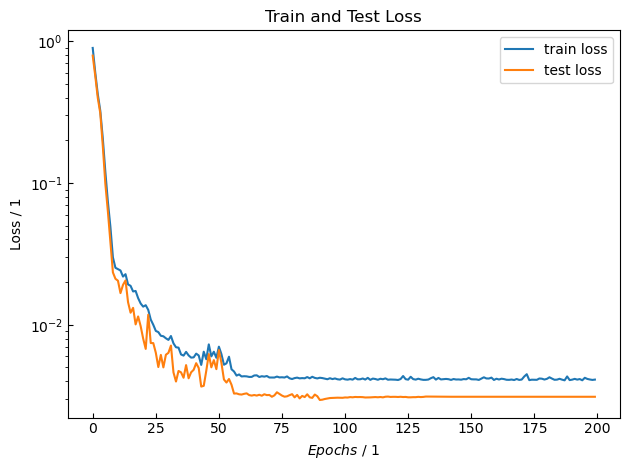

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9971353334450261 , R^2(NH3) = 0.9945677140240103
Test Dataset: R^2(H2) = 0.9969597060226416 , R^2(NH3) = 0.9962780592747348
Max Error Training: |x_H2 - x_H2,pred| = 0.04596521065003195 , |x_NH3 - x_NH3,pred| = 0.050642645065287456
Max Error Test: |x_H2 - x_H2,pred| = 0.03647935345507103 , |x_NH3 - x_NH3,pred| = 0.026216931919001485


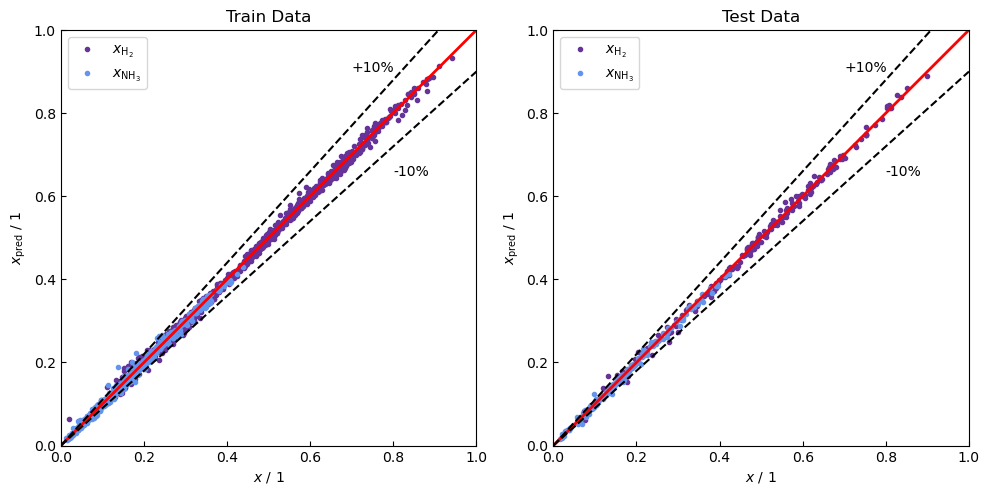

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

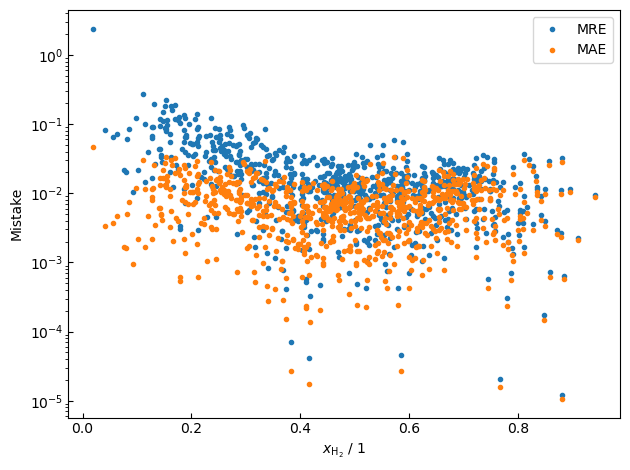

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

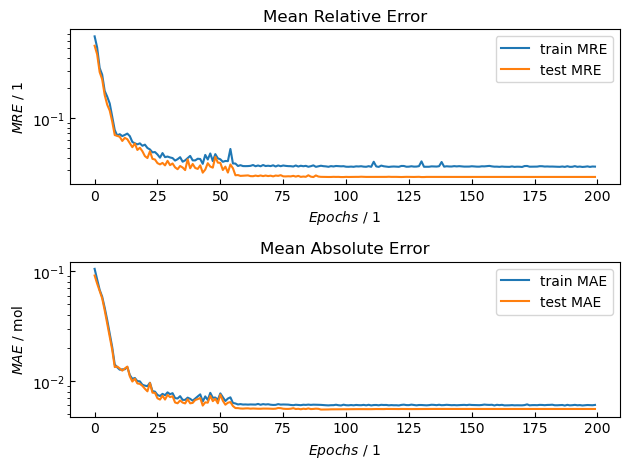

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

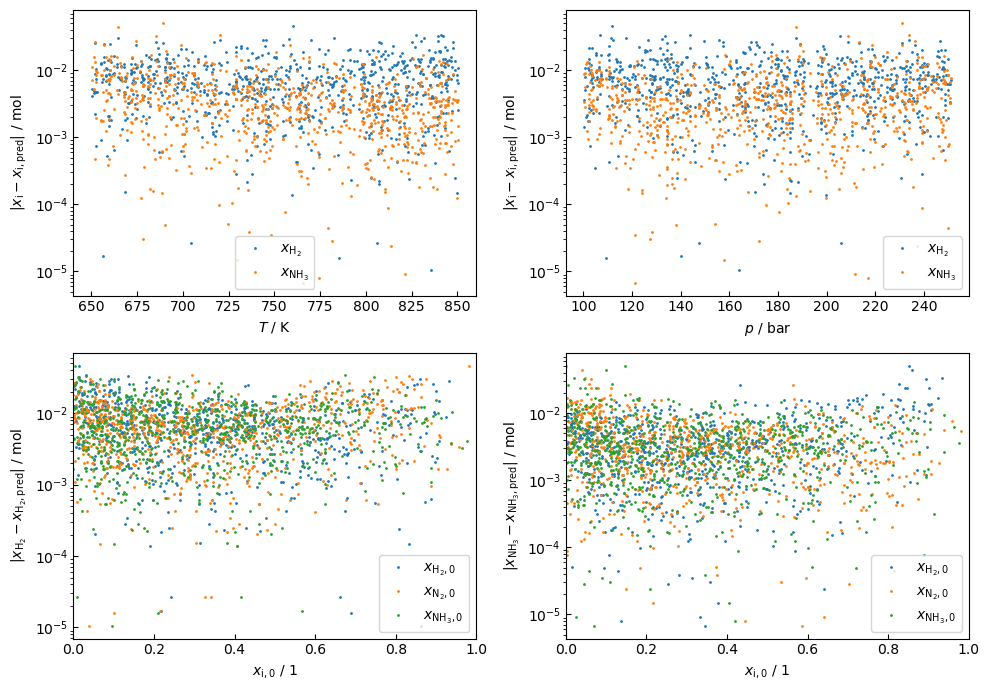

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

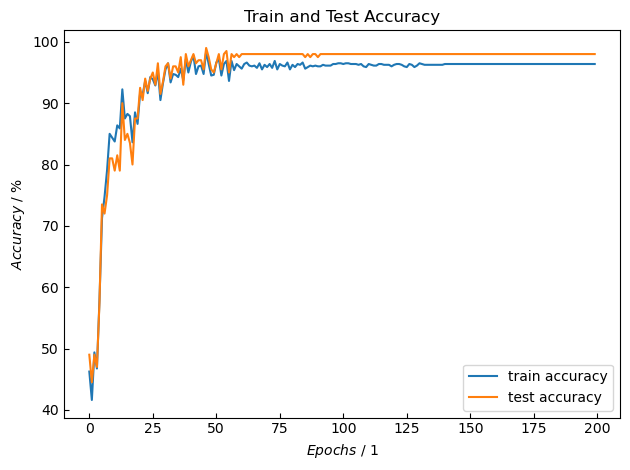

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.015625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.7401,  1.6670,  1.1262,  0.2861, -1.3977],
        [-0.8798, -0.6236,  1.1565, -0.4773, -0.6471],
        [-1.6445,  1.6613, -1.3740,  0.8788,  0.4502],
        [-0.6698,  1.0401,  2.1113, -1.1116, -0.9358],
        [-1.1546, -1.0749,  1.0006,  0.2316, -1.2187],
        [ 0.2975,  1.5856,  0.6358, -0.3634, -0.2525],
        [ 0.8406, -0.7978, -0.5431,  1.7401, -1.2455],
        [-0.1515, -0.2196, -1.3450,  2.0374, -0.7625],
        [ 1.3560,  0.2020, -1.0822, -0.5786,  1.6535],
        [ 0.4074, -1.6347, -0.1282,  0.4852, -0.3701],
        [ 1.4271, -1.3029,  0.9939, -1.1879,  0.2387],
        [ 0.4045,  1.6978, -0.8808,  1.9873, -1.1668],
        [-1.0372,  1.1801, -0.5317, -0.1352,  0.6600],
        [ 0.9407, -0.1802,  1.4081, -0.7077, -0.6585],
        [ 1.0499, -0.8096, -1.2616, -0.9861,  2.2460],
        [-1.4236, -0.5043, -0.3598,  0.8092, -0.4740],
        [ 1.3533,  0.7942,  0.4791, -0.8365,  0.3848],
        [ 1.6188,  0.9871,  0.0479,  0.5436, -0.6027],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.2987, -0.2087,  0.2948, -0.1888,  0.2810],
         [-0.5334,  0.1650,  0.1133, -0.5772,  0.0221],
         [-0.5138,  0.1583, -0.2630,  0.6779, -0.1618],
         [ 0.2176, -0.0768, -0.3339,  0.5109, -0.3422],
         [ 0.0128,  0.0518,  0.6130, -0.5162,  0.0748]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0864, -0.0668,  0.9491, -0.0773, -0.6845], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4153, -0.6371,  0.7272,  0.3385, -1.0350],
         [-0.4546,  0.0731,  0.7506, -0.0590, -0.2455],
         [-0.0596,  0.6049,  0.4186, -0.8331, -0.5546],
         [ 0.0952,  0.4880,  0.5963,  0.6826, -0.6022],
         [ 0.5090,  0.2995, -0.2426, -0.4150,  0.6190]], requires_grad=True),
 Parameter containing:
 tensor([0.4148, 0.6038, 0.5936, 0.0371, 0.1563], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0067, -0.2583,  0.0293, -0.5567,  1.0594],
         [-1.1577,  0.5606,  1.2224,  0.2924, -0.3908]], requires_grad=True),


In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.5652, 0.5562, 0.7861, 0.5953, 0.5121],
        [0.5427, 0.5772, 0.9511, 0.1804, 0.9738]])
tensor([[ 0.1487, -0.3357],
        [ 0.5878, -0.3792]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-9.8570e-01,  7.6694e-01,  1.4802e+00, -3.4036e-01, -1.1048e+00],
        [ 1.7353e-01,  1.4731e+00,  1.2030e+00, -1.8617e-01, -9.9034e-01],
        [ 5.7882e-01,  3.0823e-01,  1.2383e+00, -5.9310e-01, -6.0910e-01],
        [-3.3372e-01, -1.1729e+00,  1.5227e+00, -1.1441e+00, -3.2502e-01],
        [ 5.4692e-02,  5.0613e-01,  2.5977e-02,  3.8258e-01, -4.1652e-01],
        [ 7.3658e-01, -1.5913e+00,  1.1921e+00, -5.1824e-01, -6.4022e-01],
        [ 8.5742e-01, -1.3616e+00,  1.5719e+00, -5.2933e-01, -1.0016e+00],
        [ 1.0638e+00,  1.7039e+00,  1.0093e-01,  1.0575e+00, -1.1799e+00],
        [ 1.1987e+00, -9.1626e-01, -8.9835e-01, -1.3440e+00,  2.2553e+00],
        [ 1.0932e-01, -2.4943e-01,  1.4727e+00, -1.2349e-01, -1.3191e+00],
        [ 1.0531e+00, -6.7937e-01,  7.9734e-02, -3.3668e-01,  2.6586e-01],
        [-1.0751e+00, -5.4105e-01, -7.6198e-01, -8.0966e-01,  1.5753e+00],
        [-9.3820e-01,  1.9071e-01,  4.2470e-01, -6.1213e-01,  2.0885e-01],
        [-1.2668e+00,  1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

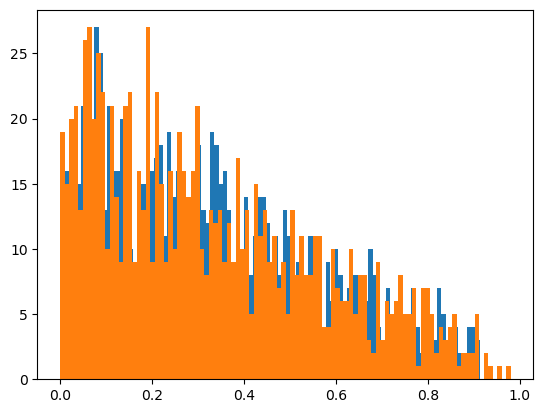

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_038.pth')
# np.savez('data/models/params_005_038.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)